# Class 14: Graph Machine Learning 1

## Goals of today's class:
1. Understand, at a high level, how to train and evaluate a classifier.
2. Implement some classifiers (that don't involve neural networks) on a network dataset.
3. Experiment with tweaking classifier type, hyperparameters, and training data size. Reason about how this impacts performance.

## Today's Dataset
The network you're about to look at is a German language network of Twitch streamers. Each node represents a user, and an edge between them means that they have a mutual friendship (so this is an undirected network). Nodes have attributes that represent streamer behavior & characteristics. To preserve users' privacy, we don't know what the features are or what a value for a particular feature means. There's a binary classification task for this dataset that involves predicting whether or not a streamer uses explicit language. 

In [172]:
import json
import pandas as pd
import networkx as nx

G = nx.read_edgelist(open('./data/twitch/DE/musae_DE_edges.csv', 'rb'), delimiter=',', nodetype=int) # edges between users
attrs = json.load(open('./data/twitch/DE/musae_DE.json')) # user attributes as dict mapping user IDs to a vector (list) of attributes
nx.set_node_attributes(G, attrs, name='ml_features') # set node attributes as attrs
uses_explicit_language = pd.read_csv('./data/twitch/DE/musae_DE_target.csv') # binary indicators of whether a streamer uses explicit language
df_attrs = pd.DataFrame([{'user': int(k)} | {'attr_' + str(ix): vv for ix, vv in enumerate(v[:10])} for k, v in attrs.items()])
df_attrs_explicit = pd.merge(df_attrs, uses_explicit_language, left_on='user', right_on='new_id')

## Basic ML Principles

Machine learning basically involves building algorithms that can learn things from data and make generalizations to new data. 
Supervised machine learning is the practice of building a model when we have training data -- the information that we use to inform our model how the world works -- that has correct ground truth answers. When you're building a linear regression or a Naive Bayes classifier (for example), you're doing supervised machine learning. 

In contrast, unsupervised machine learning (which we won't be doing much of today) is useful when we don't have access to exact ground truths about desired outcomes, but we have to build insights with our dataset anyway. When we do unsupervised ML, we figure out what patterns are present in unlabeled data. Clustering is one type of unsupervised machine learning technique; when we cluster a dataset, we're learning to recognize similar kinds of data points. Generating new examples is also (kind of) an unsupervised ML task. Training GPT and its ilk to produce language requires massive amounts of scraped text that doesn't have "answers" attached to it per se. Humans aren't going through and labeling the terabytes of data that GPT is trained on (before it is fine-tuned for specific tasks). Instead, at a high level, GPT and friends are trained to produce text that we can't tell comes from a computer -- it should "look like" the text that showed up in the massive amounts of data it was trained on. Once GPT has been trained in this fashion, it is also fine-tuned for specific tasks -- this is where human labeling and direction do come in.

Today, when we talk about doing machine learning we're going to mostly focus on supervised ML, specifically *binary classification*. Binary classification involves learning to answer a yes-or-no question about a given data point. 

### Train/Test Splits
Training models requires training data and test data at minimum. Our training data is what the model learns patterns from, and the test data tells us how well the model does on data it hasn't seen before. 

**If we were to test on the same data we trained on, what could potentially happen?**

When we construct training and testing sets, we need to make sure the data that we use for training is as akin to the test data as we can make it. We usually accomplish this by randomly splitting the dataset into two parts. In this case, we'll be using `sklearn`, also known as `scikit-learn`, which is a general-purpose machine learning library for Python. `sklearn` has a handy function called `train_test_split` that we can use to generate a training set and test set that are randomly selected. We can also set the `random_seed` parameter to be a fixed number; this will ensure that we get the same train/test split every time. 

In [173]:
from sklearn.model_selection import train_test_split
df_attrs_explicit = df_attrs_explicit.fillna(0.0)
explicit_train, explicit_test = train_test_split(df_attrs_explicit, test_size=0.3, random_state=42)
print('The training set length is', len(explicit_train), 'and the test set length is', len(explicit_test))

The training set length is 6648 and the test set length is 2850


### Measuring How Well We Do
The next thing we have to think about, once we've trained our model, is evaluating how well it performs on held-out data (i.e. the test set). For a binary classifier, we can define four kinds of events that might occur:
|      | True Value: 1      | True Value: 0   |
| ------------| --------------- | --------- |
| Predicted Value: 1 | True Positive (TP) | False Positive (FP) |
| Predicted Value: 0 | False Negative (FN) | True Negative (TN) |

There are a few ways we can measure how well a binary classifier does, and sometimes we need to look at several measures in order to get a full picture of itss performance.

| Measure     | Definition      | Formula   |
| ------------| --------------- | --------- |
| Accuracy | How often do we get it right?  | $\frac{TP + TN}{TP + FP + TN + FN}$ |
| Recall | How many true positives do we detect out of all positive examples? | $\frac{TP}{TP + FN}$ |
| Precision| How many of our positive classifications are truly positive? | $\frac{TP}{TP + FP}$ | 
| F1 Score | Harmonic mean of precision and recall | $\frac{2TP}{2TP + FP + FN}$ |

Let's try a toy example using the dataframe with user attributes and explicit language usage. `sklearn` has a lot of classifiers; right now we're going to try using a [random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Random forest classifiers consist of many decision tree classifiers, each of which is trained on a different subset of the training dataset. Broadly speaking, decision tree classifiers learn decision rules from the data; they can be very complicated, but you can also force them to limit their breadth or depth. The average prediction output by all the decision trees for a particular data point is the classifier's final output. 

In [174]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

explicit_train_x = explicit_train[[c for c in explicit_train.columns if 'attr_' in str(c)]].to_numpy()
explicit_test_x = explicit_test[[c for c in explicit_train.columns if 'attr_' in str(c)]].to_numpy()

explicit_train_y = explicit_train['mature'].to_numpy()
explicit_test_y = explicit_test['mature'].to_numpy()

# clf = DecisionTreeClassifier()
clf = RandomForestClassifier(criterion='log_loss')
clf.fit(explicit_train_x, explicit_train_y.ravel())
preds = clf.predict(explicit_test_x)


In [175]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

print('accuracy score:', accuracy_score(explicit_test_y, preds))
print('precision:', precision_score(explicit_test_y, preds))
print('recall:', recall_score(explicit_test_y, preds))
print('F1:', f1_score(explicit_test_y, preds))
tn, fp, fn, tp = confusion_matrix(explicit_test_y, preds).ravel().tolist()
print()
print('Rate of True Negatives Correctly Identified:', tn / (tn + fp))
print('False Positives Out of All Negative Labels (false alarm rate):', fp / (fp + tn))
print('False Negatives Out of All Positive Labels (failure to detect):', fn / (fn + tp))
print('Rate of True Positives Correctly Identified:', tp / (tp + fn))

accuracy score: 0.6207017543859649
precision: 0.6512388966806919
recall: 0.8061342592592593
F1: 0.7204551331781743

Rate of True Negatives Correctly Identified: 0.33511586452762926
False Positives Out of All Negative Labels (false alarm rate): 0.6648841354723708
False Negatives Out of All Positive Labels (failure to detect): 0.19386574074074073
Rate of True Positives Correctly Identified: 0.8061342592592593


### Hyperparameters
Let's see if we can tweak our decision tree classifier a bit. When we talk about *hyperparameters* in machine learning, we're referring to the parameters that govern a model's behavior, not the parameters that the model learns itself in order to fit the data. For a decision tree, we might control its depth or the maximum number of leaf nodes it's allowed to make. When we are working with a classifier to figure out the best hyperparameters, we still don't want to use our test set to see how well we're doing when we change hyperparameters. Instead, we'll add another split to the dataset, known as the *validation set*. We use the validation set to see how well we perform on data we didn't see in training; this lets us tune our hyperparameters effectively before we see how well our final model performs on the test set.  

Text(0, 0.5, 'Score')

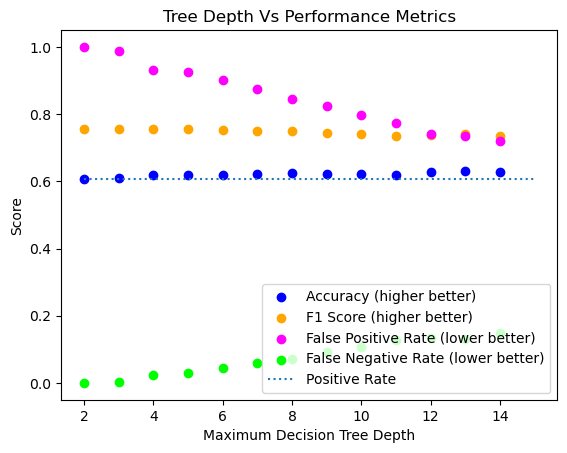

In [176]:
import numpy as np
explicit_train, explicit_val = train_test_split(df_attrs_explicit, test_size=0.3, random_state=42)
explicit_train_x = explicit_train[[c for c in explicit_train.columns if 'attr_' in str(c)]].to_numpy()
explicit_val_x = explicit_val[[c for c in explicit_train.columns if 'attr_' in str(c)]].to_numpy()

explicit_train_y = explicit_train['mature'].to_numpy()
explicit_val_y = explicit_val['mature'].to_numpy()

accuracies = []
f1s = []
false_alarms = []
failed_detections = []
for depth in range(2, 15):
    clf = RandomForestClassifier(max_depth=depth)
    clf.fit(explicit_train_x, explicit_train_y.ravel())
    preds = clf.predict(explicit_val_x)
    accuracies.append(accuracy_score(explicit_val_y, preds))
    f1s.append(f1_score(explicit_val_y, preds))
    tn, fp, fn, tp = confusion_matrix(explicit_val_y, preds).ravel().tolist()
    false_alarms.append(fp / (fp + tn))
    failed_detections.append(fn / (fn + tp))
    
plt.scatter([i for i in range(2, 15)], accuracies, color='blue', label='Accuracy (higher better)')
plt.scatter([i for i in range(2, 15)], f1s, color='orange', label='F1 Score (higher better)')
plt.scatter([i for i in range(2, 15)], false_alarms, color='magenta', label='False Positive Rate (lower better)')
plt.scatter([i for i in range(2, 15)], failed_detections, color='lime', label='False Negative Rate (lower better)')
plt.plot([2, 15], [np.mean(explicit_val_y), np.mean(explicit_val_y)], linestyle=':', label='Positive Rate')
plt.legend()
plt.title('Tree Depth Vs Performance Metrics')
plt.xlabel('Maximum Decision Tree Depth')
plt.ylabel('Score')

As you can see, we aren't doing much better than random guessing right now. 

**What does that mean about how useful our classifier is?**

Let's see what happens when we incorporate information about the network into our classification. 

## Collective Classification
When we do collective classification, we have two variables: a graph $G$ and a node $v \in G$ that we want to label (classify). Some of $v$'s neighbors are labeled, and some are not. In this setting, we can classify $v$ based on any subset of the following:
1. The correlation between $v$'s label and its observed attributes (this is what we just tried!)
2. The correlation between $v$'s label and its neighbors' known labels and observed attributes
3. The correlation between $v$'s label and its unlabeled neighbors' unknown labels.

A lot of the collective classification methods discussed [here](https://onlinelibrary.wiley.com/doi/10.1609/) (paper coauthored by our very own Dr. Tina Eliassi-Rad) involve horrifying amounts of statistical inference, which is beyond the scope of this class. However, one of the methods discussed there, *iterative classification*, is fairly tractable. Let's take a look!

### Iterative Classification
First, you choose a local classifier, $f$, that can be used to determine the label of a node given the labels (seen & unseen) of its neighbors. Tina calls this “guilt by association”. Your local classifier $f$ can give you a label outright, or it can give you a probability distribution over labels (in which case you pick the label that gives you the best value). Since real-world networks notably do not have fixed degree, but most classifiers assume fixed-length feature vectors, we can’t just feed an arbitrary-length vector into any function $f$. Instead, we have to come up with some sort of pooling function, like MAX, COUNT, MEAN, SUM, etc. and pool the labels in some pre-determined way.

We then move on to the actual labeling business. First, we do a “bootstrapping” step – we label each node using our incomplete information, giving it our best guess. Next, we do the iterative classification process. Each time, we generate a new ordering
O of nodes, then we go through and label each node according to what its neighbors are currently labeled as, using $f$. We do this a bunch of times until the labels stop changing or we’ve gone through a pre-determined number of iterations, after which we should give up.

In [233]:
explicit_train_ic, explicit_test_ic = train_test_split(df_attrs_explicit, test_size=0.5, random_state=42)
map_train = {user: mature for user, mature in zip(explicit_train_ic['user'], explicit_train_ic['mature'])}
map_test = {user: mature for user, mature in zip(explicit_test_ic['user'], explicit_test_ic['mature'])}

def local_classifier(neighbor_labels):
    """
    Given a list of neighbor labels, return True if there are at least 4 True values in the list.
    """
    return np.sum(neighbor_labels) >= 4

def iterative_classification(G, map_train, map_test, local_classifier=local_classifier, max_iter=20):
    """
    Perform the iterative classification algorithm on the network G given split train and test sets.

    Inputs:
    G: networkx graph object; should have the same nodes as the keys in map_train and map_test combined.
    map_train and map_test: dicts; mappings from the nodes in the train & test sets to their binary classification ground truth.
    local_classifier: function that takes in a list of boolean values and returns a single boolean value
    max_iter: denotes how many iterations to do before stopping (if no convergence occurs).

    Returns:
    labels: mapping over the entire dataset (with labels from map_train preserved) from nodes to their binary classification.
    """
    labels = {v: 0 for v in map_test.keys()}
    for node in map_test.keys():
        neighbors = G.neighbors(node)
        neighbor_labels = [map_train[n] for n in neighbors if n in map_train]
        labels[node] = local_classifier(neighbor_labels)
        
    labels = labels | map_train
    n_iter = 0
    nodes_list = [k for k in map_test.keys()]
    while n_iter < max_iter:
        prev_labels = labels.copy()
        np.random.shuffle(nodes_list)
        for node in nodes_list:
            neighbors = G.neighbors(node)
            neighbor_labels = [prev_labels[n] for n in neighbors]
            labels[node] = local_classifier(neighbor_labels)
        if labels == prev_labels:
            return labels
        n_iter += 1
    return labels

labels = iterative_classification(G, map_train, map_test, local_classifier=local_classifier, max_iter=20)

ground_truth = []
preds = []
for k, v in map_test.items():
    preds.append(labels[k])
    ground_truth.append(v)



In [234]:
print('accuracy score:', accuracy_score(ground_truth, preds))
print('precision:', precision_score(ground_truth, preds))
print('recall:', recall_score(ground_truth, preds))
print('F1:', f1_score(ground_truth, preds))
tn, fp, fn, tp = confusion_matrix(ground_truth, preds).ravel().tolist()
print()
print('Rate of True Negatives Correctly Identified:', tn / (tn + fp))
print('False Positives Out of All Negative Labels (false alarm rate):', fp / (fp + tn))
print('False Negatives Out of All Positive Labels (failure to detect):', fn / (fn + tp))
print('Rate of True Positives Correctly Identified:', tp / (tp + fn))

accuracy score: 0.6321330806485576
precision: 0.6441244535870404
recall: 0.8734309623430963
F1: 0.7414533076809234

Rate of True Negatives Correctly Identified: 0.2642211589580011
False Positives Out of All Negative Labels (false alarm rate): 0.735778841041999
False Negatives Out of All Positive Labels (failure to detect): 0.12656903765690378
Rate of True Positives Correctly Identified: 0.8734309623430963


### Your Turn!
Can you toy with the `local_classifier` function to produce better performance with this classification algorithm?

## Edge Prediction
### Similarity-Based Methods
#### A Limited Whirlwind Tour of Similarity Measures

### Classifier-Based Methods
#### What is a classifier?
#### A Limited Whirlwind Tour of Classifiers

## *ToVec
### Detour: Word2Vec
### Actually Relevant: Node2Vec
#### What can we do with these embeddings?